<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/1e_regresion_lineal_tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión lineal: tarea


<div style="text-align: right"> Bere et Richardt </div>

---



Entrena un modelo de regresión lineal que considere los dos atributos de entrada.

* Grafica los datos en 3D.
* Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio nivel.
* Prueba distintos valores para los hiperparámetros.
* Realiza una predicción con tu modelo entrenado para la calificación que tendría un alumno si sabemos que estudió durante 12 horas para el examen y en un examen previo obtuvo 3 de calificación.
* Discute las modificaciones que realizaste y las distintas configuraciones para los hiperparámetros que probaste.

# Blibliotecas

In [1]:
# sistema de archivos
import os
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# arreglos multidimensionales
import numpy as np
import cupy as cp
# csv
import pandas as pd

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as vutils

from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_url


# directorio de datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/califs/califs.csv'
base_dir = '../data/califs/'
filename = 'califs.csv'
filepath = os.path.join(base_dir, 'califs.csv')

# para reproducibilidad
# SEED = 0
# torch.manual_seed(SEED)

# Obtención y análisis de datos

In [2]:
# Datos desde el repositorio
download_url(URL, base_dir, filename)

Using downloaded and verified file: ../data/califs/califs.csv


In [3]:
#Leemos el archivo y lo ponemos en un DF para buen manejo de datos desde CSV
df = pd.read_csv(filepath, names=['calif anterior','horas de estudio','calificación'])
df.tail(5)

,calif anterior,horas de estudio,calificación
45,6.674,13.745,8.523
46,7.259,13.821,8.106
47,7.214,13.990,8.380
48,8.751,13.992,9.149
49,8.890,14.450,8.607


<IPython.core.display.Javascript object>


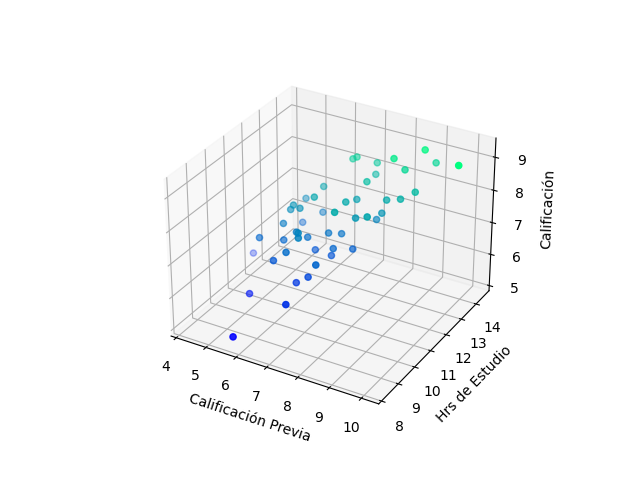

Text(0.5, 0, 'Calificación')

In [14]:
# Gráfica para análisis visual del comportamiento del conjunto de datos
fig = plt.figure()
ax = plt.axes(projection='3d')
#Se obtienen las entradas
x_trn = np.array(df.iloc[:,0:2], dtype="float32")#[..., np.newaxis]
# se obtiene la salda
y_trn = np.array(df.iloc[:,-1], dtype="float32")[..., np.newaxis]
# graficamos
ax.scatter3D(x_trn[:,0], x_trn[:,1], y_trn, c=y_trn, cmap='winter');
plt.xlabel('Calificación Previa')
plt.ylabel('Hrs de Estudio')
ax.set_zlabel('Calificación')

# Tuberias con Pytorch para Dataset y DataLoader

<!-- ![data](https://raw.githubusercontent.com/bereml/cap-2021-1/blob/master/figs/dataloader.png) -->

![data](../figs/regresion_lineal_datos.png)

In [5]:
#Clase para tener el Dataset. 
class CalifDS:
    #Inicializamos
    def __init__(self, X, Y):
        self.x = X
        self.y = Y
    #Obtenemos la información de entrada y salida
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    # Verificamos y obtenemos dimensiones
    def __len__(self):
        return len(self.y)

In [6]:
# tamaño del lote
batch_size = 16

# creamos un Dataset
ds = CalifDS(x_trn, y_trn)

# creamos un DataLoader
trn_dl4 = DataLoader(ds, batch_size=4, shuffle=True)
trn_dl8 = DataLoader(ds, batch_size=8, shuffle=True)
trn_dl16 = DataLoader(ds, batch_size=16, shuffle=True)

DLS = [trn_dl4,trn_dl8,trn_dl16]

# desplegamos un lote de imágenes y verificamos que tengas las dimensiones correctas en este caso x.shape = [16,2]
cont = 2
for trn_dl in DLS:
    cont *= 2
    for x, y in take(trn_dl, 1):
        print('For batchsize:', cont)
        print(f'x shape={x.shape} dtype={x.dtype}')
        print(f'y shape={y.shape} dtype={y.dtype}')
        print('\n')
print('\n Verificando dimensión original del dataset:', len(ds))

For batchsize: 4
x shape=torch.Size([4, 2]) dtype=torch.float32
y shape=torch.Size([4, 1]) dtype=torch.float32


For batchsize: 8
x shape=torch.Size([8, 2]) dtype=torch.float32
y shape=torch.Size([8, 1]) dtype=torch.float32


For batchsize: 16
x shape=torch.Size([16, 2]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32



 Verificando dimensión original del dataset: 50


# Cranción de Modelos con API de diferentes niveles

In [7]:
# Creación de modelo a alto nivel
model = nn.Sequential(
    nn.Linear(2, 1)
)

In [8]:
# Creación de modelo a medio nivel
# se define la clase RegLin que hereda de torch.nn.Module
class RegLin(nn.Module):

    #se define el inicializador
    def __init__(self):
        # se llama al inicializador de la clase padre
        super(RegLin, self).__init__()
        # importante: se definen las capas como atributos de la clase
        self.fc = nn.Linear(2, 1)

    # método para inferencia
    def forward(self, x):
        # definición de arquitectura 
        return self.fc(x)

#model = RegLin()

# Entrenamiento

In [9]:
learning_rates = np.random.uniform(8e-6, 1e-3, 5)

loss_accum = {}

for j in DLS:
    for i in learning_rates:
        opt, loss, y_lgts = None, None, None
        opt = optim.SGD(model.parameters(), lr=i)

        # historial de pérdida
        loss_hist = []

        # ciclo de entrenamiento
        EPOCHS = 3
        for _ in range(EPOCHS):
            
            # entrenamiento de una época
            for x, y_true in j:
                # hacemos inferencia para obtener los logits
                y_lgts = model(x)
                # calculamos de pérdida
                loss = F.mse_loss(y_lgts, y_true)
                # vaciamos los gradientes
                opt.zero_grad()
                # retropropagamos
                loss.backward()
                # actulizamos parámetros
                opt.step()

                # guardamos historial de pérdida
                loss_hist.append(loss.item() * 100)
        
        print('Con tamaño de Batch:{} y Tasa de aprendizaje:{:.2e}, la perdida media es:{:.2f}'.format(j.batch_size, i, np.mean(loss_hist)))
        loss_accum['BS:{}, LR:{:.2e}'.format(j.batch_size, i)] = loss_hist

#print(loss_hist)

Con tamaño de Batch:4 y Tasa de aprendizaje:7.58e-04, la perdida media es:35.32
Con tamaño de Batch:4 y Tasa de aprendizaje:3.78e-04, la perdida media es:22.08
Con tamaño de Batch:4 y Tasa de aprendizaje:1.92e-04, la perdida media es:21.74
Con tamaño de Batch:4 y Tasa de aprendizaje:9.28e-04, la perdida media es:23.61
Con tamaño de Batch:4 y Tasa de aprendizaje:3.11e-04, la perdida media es:21.81
Con tamaño de Batch:8 y Tasa de aprendizaje:7.58e-04, la perdida media es:20.64
Con tamaño de Batch:8 y Tasa de aprendizaje:3.78e-04, la perdida media es:20.46
Con tamaño de Batch:8 y Tasa de aprendizaje:1.92e-04, la perdida media es:19.93
Con tamaño de Batch:8 y Tasa de aprendizaje:9.28e-04, la perdida media es:22.21
Con tamaño de Batch:8 y Tasa de aprendizaje:3.11e-04, la perdida media es:24.84
Con tamaño de Batch:16 y Tasa de aprendizaje:7.58e-04, la perdida media es:18.68
Con tamaño de Batch:16 y Tasa de aprendizaje:3.78e-04, la perdida media es:18.32
Con tamaño de Batch:16 y Tasa de apren

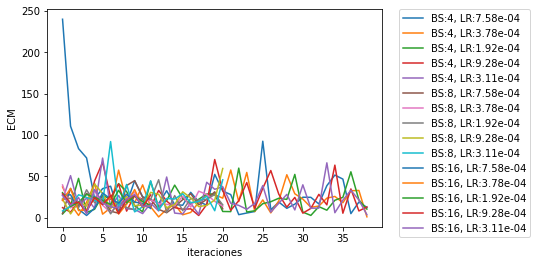

In [10]:
ll=[]
for k in loss_accum:
    ll.append(k)
# Graficando la perdida
%matplotlib inline
h = -1
for i in ll:
    h += 1
    plt.plot(loss_accum[i], label = ll[h])
# plt.plot(loss_accum[ll[0]])
plt.xlabel('iteraciones')
plt.ylabel('ECM');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [11]:
# Obtenemos los parámetros del modelo.
[w, b] = model.parameters()
print('Valor de los pesos w1 y w2:', w, '\n\t')
print('Valor del sesgo b:', b)

Valor de los pesos w1 y w2: Parameter containing:
tensor([[0.0787, 0.6158]], requires_grad=True) 
	
Valor del sesgo b: Parameter containing:
tensor([-0.6242], requires_grad=True)


# Inferencia y predicción

<IPython.core.display.Javascript object>


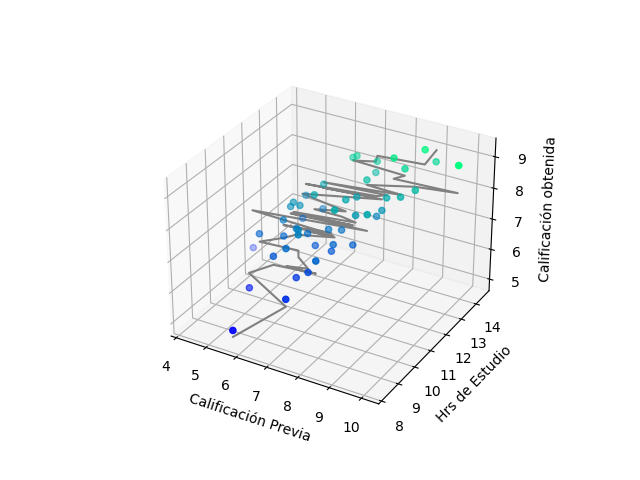

Text(0.5, 0, 'Calificación obtenida')

In [12]:
#Graficamos el modelo con la dispersión de puntos
%matplotlib notebook

x_train = torch.from_numpy(x_trn)

with torch.no_grad():
    y_pred = model(x_train).numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')

# graficamos
ax.plot3D(x_trn[:,0].flatten(), x_trn[:,1].flatten(), y_pred.flatten(), 'gray')
ax.scatter3D(x_trn[:,0], x_trn[:,1], y_trn, c=y_trn, cmap='winter');
plt.xlabel('Calificación Previa')
plt.ylabel('Hrs de Estudio')
ax.set_zlabel('Calificación obtenida')

In [13]:
#Se realiza la predicción para alumno con 12 hrs. de estudio y 3 como calificación previa
x = torch.tensor([[3.0,12.0]])

# deshabilitamos el rastreo de gradientes
with torch.no_grad():
    y_pred = model(x).numpy()

print("La calificación será:", y_pred[0][0])

La calificación será: 7.001947


**Discución de resultados.**
Las modificaciones realizadas, se hicieron desde la preparación de los datos, donde ajustamos las dimensiones de X para que contenga los dos atributos, es decir calificación previa, y horas de estudio. Además al momento del diseño de la arquitectura tanto con el api de alto como la de medio nivel se ajustaron las dimensiones de entrada, para que acepte los dos atributos. Además de esto, se probó con distintos tamaños de lote y tasas de aprendizaje, donde de acuerdo a los resultados obtenidos la media de la pérdida fue muy similar para todas las combinaciones, pero mostrando mayores cambios entre conforme al tamaño de lote, más que a la tasa de aprendizaje. Donde con el tamaño de lote más grande, es decir 16 se obtuvo menor pérdida media. 